In [1]:
import pandas as pd
from pandas import read_csv

In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [25]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [2]:
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/datasets/finales/"
filename = "affluent_std copy.csv"
dataset = read_csv(folder + filename,parse_dates = ['hour'], index_col = ['hour'])
del dataset['index']
dataset.rename(columns = {'energy(kWh/hh)':'energy'}, inplace = True) 

In [3]:
dataset.head()

,energy,temperature,pressure,wind_speed,humidity,weekend
hour,,,,,,
2012-01-01 00:00:00,0.234250,13.49,1008.14,3.11,0.88,1
2012-01-01 00:30:00,0.213458,13.49,1008.14,3.11,0.88,1
2012-01-01 01:00:00,0.236750,12.73,1007.88,3.08,0.93,1
2012-01-01 01:30:00,0.207667,12.73,1007.88,3.08,0.93,1
2012-01-01 02:00:00,0.193708,13.65,1007.09,3.71,0.91,1


Data Perparation

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.248835   0.502892   0.479432   0.218195   0.844156        1.0  0.214214
2   0.214214   0.502892   0.479432   0.218195   0.844156        1.0  0.252998
3   0.252998   0.482913   0.475585   0.216063   0.909091        1.0  0.204570
4   0.204570   0.482913   0.475585   0.216063   0.909091        1.0  0.181328
5   0.181328   0.507098   0.463896   0.260839   0.883117        1.0  0.141156


Define and Fit Model

In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 32112
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(32112, 1, 6) (32112,) (2927, 1, 6) (2927,)


Train on 32112 samples, validate on 2927 samples
Epoch 1/50
 - 2s - loss: 0.0509 - val_loss: 0.0271
Epoch 2/50
 - 1s - loss: 0.0263 - val_loss: 0.0268
Epoch 3/50
 - 1s - loss: 0.0262 - val_loss: 0.0268
Epoch 4/50
 - 1s - loss: 0.0261 - val_loss: 0.0269
Epoch 5/50
 - 1s - loss: 0.0261 - val_loss: 0.0269
Epoch 6/50
 - 1s - loss: 0.0260 - val_loss: 0.0269
Epoch 7/50
 - 1s - loss: 0.0259 - val_loss: 0.0269
Epoch 8/50
 - 1s - loss: 0.0259 - val_loss: 0.0270
Epoch 9/50
 - 1s - loss: 0.0259 - val_loss: 0.0271
Epoch 10/50
 - 1s - loss: 0.0258 - val_loss: 0.0271
Epoch 11/50
 - 1s - loss: 0.0258 - val_loss: 0.0272
Epoch 12/50
 - 1s - loss: 0.0258 - val_loss: 0.0273
Epoch 13/50
 - 1s - loss: 0.0258 - val_loss: 0.0274
Epoch 14/50
 - 1s - loss: 0.0258 - val_loss: 0.0274
Epoch 15/50
 - 1s - loss: 0.0258 - val_loss: 0.0276
Epoch 16/50
 - 1s - loss: 0.0257 - val_loss: 0.0277
Epoch 17/50
 - 1s - loss: 0.0257 - val_loss: 0.0277
Epoch 18/50
 - 1s - loss: 0.0257 - val_loss: 0.0279
Epoch 19/50
 - 1s - loss

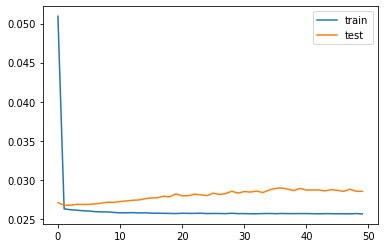

In [29]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluate Model

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('MAE', metrics.mean_absolute_error(inv_y, inv_yhat))

Test RMSE: 0.022
MAE 0.017141769


In [ ]:
''' https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ '''